# **Modules**

In [1]:
# Util libraries
import os
import re
import random
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
#!pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

# SKLearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            cohen_kappa_score, roc_auc_score, confusion_matrix

# TF
#!pip install tensorflow_hub
import tensorflow_hub as hub

# Tensorflow Keras
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.utils import to_categorical

# **Read Data**
Similar process to the CNN-LSTM_Company_Stock_Movements_News variant

In [2]:
# Company ticker symbol
ticker = "TSLA"

# Data files
stock_price_file = f"../data/{ticker}/raw_data/daily_{ticker}.csv"
news_file = f"../data/{ticker}/raw_data/news_{ticker}.json"

# Read the stock price data
stock_price_df = pd.read_csv(stock_price_file)

# Read the news data
news_df = pd.read_json(news_file)

# **Preprocess Stock Price Data**

In [3]:
# Inspect the stock price data
stock_price_df.head()

,timestamp,open,high,low,close,volume
0,2020-11-06,436.10,436.5700,424.2800,429.95,21706014
1,2020-11-05,428.30,440.0000,424.0001,438.09,28414523
2,2020-11-04,430.62,435.4000,417.1000,420.98,32143057
3,2020-11-03,409.73,427.7700,406.6900,423.90,34351715
4,2020-11-02,394.00,406.9799,392.3000,400.51,29021118


In [4]:
def label_diff(row):
  # Label the difference (one-hot-encoding)
  # [0, 0, 0] - Trend Stay
  # [0, 1, 0] - Trend Up
  # [0, 0, 2] - Trend Down

  # Return [0, 0, 0] (Trend Stay) if NaN
  if row["diff"] == "NaN":
    label_count["stay"] += 1
    return [0, 0, 0]
  
  # Return [0, 1, 0] (Trend Up) if price difference between today and yesterday is >= $5
  elif row["diff"] >= 5:
    label_count["up"] += 1
    return [0, 1, 0]
  
  # Return [0, 0, 1] (Trend Down) if price difference between today and yesterday is <= -$5
  elif row["diff"] <= -5:
    label_count["down"] += 1
    return [0, 0, 1]
  
  # Else, return [0, 0, 0] (Trend Stay)
  else:
    label_count["stay"] += 1
    return [0, 0, 0]

In [5]:
# Keep track of the count per classes/ labels
label_count = {
    "stay": 0,
    "up": 0,
    "down": 0
}

# Subset the stock price date range according to the news data
stock_price_df = stock_price_df[stock_price_df["timestamp"].isin(news_df["publishedAt"])][["timestamp", "open"]].sort_values(by=['timestamp'])

# Calculate the price difference based on previous day's open price
stock_price_df["diff"] = stock_price_df["open"].diff()

# Create label based on price difference
label = stock_price_df.apply(lambda row: label_diff(row), axis = 1)
stock_price_df["label"] = label

stock_price_df

,timestamp,open,diff,label
22,2020-10-07,419.8700,NaN,"[0, 0, 0]"
21,2020-10-08,438.4400,18.5700,"[0, 1, 0]"
20,2020-10-09,430.1300,-8.3100,"[0, 0, 1]"
19,2020-10-12,442.0000,11.8700,"[0, 1, 0]"
18,2020-10-13,443.3500,1.3500,"[0, 0, 0]"
17,2020-10-14,449.7800,6.4300,"[0, 1, 0]"
16,2020-10-15,450.3100,0.5300,"[0, 0, 0]"
15,2020-10-16,454.4400,4.1300,"[0, 0, 0]"
14,2020-10-19,446.2400,-8.2000,"[0, 0, 1]"
13,2020-10-20,431.7500,-14.4900,"[0, 0, 1]"


In [6]:
# Lowest and highest open price
print("Lowest  open price:", min(list(stock_price_df["open"])))
print("Highest open price:", max(list(stock_price_df["open"])))

Lowest  open price: 394.0
Highest open price: 454.44


In [7]:
# Label count for each class
print("Labels count:", label_count)

Labels count: {'stay': 6, 'up': 8, 'down': 9}


# **Merge News & Stock Data**

In [8]:
# Inspect the news data
news_df.head()

,title,description,publishedAt
0,Tesla finally launches two-factor authentication,"b'After a long string of delays, Tesla has fin...",2020-10-07
1,Tesla has a shot at producing half a million c...,b'Tesla Inc <TSLA.O> has a chance at producing...,2020-10-07
2,Ex,"b""Tesla co-founder J.B. Straubel wants to buil...",2020-10-07
3,SpaceX has launched enough satellites for Star...,b'Timeline uncertain because newly launched sa...,2020-10-07
4,SpaceX doubled down on clearing out the villag...,"b""Summary List PlacementSpaceX has made what i...",2020-10-07


In [9]:
# Merge on timestamp
news_stock_label_df = pd.merge(news_df, stock_price_df[["timestamp", "label"]], left_on="publishedAt", right_on="timestamp")[["title", "description", "timestamp", "label"]]

# Label is the stock trend movement: 
# [0, 0, 0] - Stay
# [0, 1, 0] - Up
# [0, 0, 1] - Down
news_stock_label_df

,title,description,timestamp,label
0,Tesla finally launches two-factor authentication,"b'After a long string of delays, Tesla has fin...",2020-10-07,"[0, 0, 0]"
1,Tesla has a shot at producing half a million c...,b'Tesla Inc <TSLA.O> has a chance at producing...,2020-10-07,"[0, 0, 0]"
2,Ex,"b""Tesla co-founder J.B. Straubel wants to buil...",2020-10-07,"[0, 0, 0]"
3,SpaceX has launched enough satellites for Star...,b'Timeline uncertain because newly launched sa...,2020-10-07,"[0, 0, 0]"
4,SpaceX doubled down on clearing out the villag...,"b""Summary List PlacementSpaceX has made what i...",2020-10-07,"[0, 0, 0]"
...,...,...,...,...
472,"Tesla unveils 'Tesla Tequila' for $250, produc...",b'Tesla Inc <TSLA.O> Chief Executive Officer E...,2020-11-06,"[0, 1, 0]"
473,Waiting for a winner was costly and other inve...,b'Investors have traditionally shied away from...,2020-11-06,"[0, 1, 0]"
474,Toyota-backed startup Pony.ai raises $267 mill...,"b'Pony.ai, backed by Toyota Motor Corp, said o...",2020-11-06,"[0, 1, 0]"
475,Toyota-backed startup Pony.ai raises $267 mill...,"b'Pony.ai, backed by Toyota Motor Corp, said o...",2020-11-06,"[0, 1, 0]"


# **Preprocess News Data**

In [10]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

In [11]:
def clean_text(row):
    # Steps:
    # 1. Lowercase words (for uncased GloVe Embeddings)
    # 2. Replace contractions with longer form (from the contractions dictionary)
    # 3. Replace and remove non-word characters (symbols)
    # 4. Remove stop words
    
    # Lowercase words
    text = row.lower()
    
    # Replace contractions with longer form
    text = text.split()
    expanded_text = []
    for word in text:
        if word in contractions:
            expanded_text.append(contractions[word])
        else:
            expanded_text.append(word)
    text = " ".join(expanded_text)
    
    # Format words and remove non-word characters
    text = re.sub(r'b\"', '', text)
    text = re.sub(r'b\'', '', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]<>]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Remove stop words
    text = text.split()
    stop_words = set(stopwords.words("english"))
    text = [word for word in text if not word in stop_words]
    
    # Return cleaned text
    cleaned_text = " ".join(text)
    
    return cleaned_text

In [12]:
# Clean the news title text
news_stock_label_df["title"] = news_stock_label_df.apply(lambda row: clean_text(row["title"]), axis = 1)

# Clean the news description text
news_stock_label_df["description"] = news_stock_label_df.apply(lambda row: clean_text(row["description"]), axis = 1)

news_stock_label_df

,title,description,timestamp,label
0,tesla finally launches two factor authentication,long string delays tesla finally implemented c...,2020-10-07,"[0, 0, 0]"
1,tesla shot producing half million cars 2020 memo,tesla inc tsla chance producing 500000 cars ye...,2020-10-07,"[0, 0, 0]"
2,ex,tesla co founder j b straubel wants build star...,2020-10-07,"[0, 0, 0]"
3,spacex launched enough satellites starlink’s u...,timeline uncertain newly launched satellites m...,2020-10-07,"[0, 0, 0]"
4,spacex doubled clearing village building rocke...,summary list placementspacex made calls final ...,2020-10-07,"[0, 0, 0]"
...,...,...,...,...
472,tesla unveils tesla tequila $ 250 product sold...,tesla inc tsla chief executive officer elon mu...,2020-11-06,"[0, 1, 0]"
473,waiting winner costly investor lessons post el...,investors traditionally shied away uncertainty...,2020-11-06,"[0, 1, 0]"
474,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]"
475,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]"


In [13]:
# Calculate word frequency and the size of the vocabulary
def calculate_word_frequency(row, word_frequency):
    
    title_text = row["title"].split()
    for word in title_text:
        if word not in word_frequency:
            word_frequency[word] = 1
        else:
            word_frequency[word] += 1
    
    description_text = row["description"].split()
    for word in description_text:
        if word not in word_frequency:
            word_frequency[word] = 1
        else:
            word_frequency[word] += 1
    
    return word_frequency

In [14]:
# Calculate word frequency and the size of the vocabulary
word_frequency = {}

news_stock_label_df.apply(lambda row: calculate_word_frequency(row, word_frequency), axis = 1)

print("Size of vocabulary: {}".format(len(word_frequency)))

Size of vocabulary: 4028


In [15]:
# Sort by word frequency (descending order starting from highest count word)
word_frequency = {k: v for k, v in sorted(word_frequency.items(), key=lambda item: item[1], reverse=True)}

# Print the list of vocabulary
for word, frequency in word_frequency.items():
    print(word, frequency)

tesla 354
$ 171
musk 166
elon 148
electric 126
new 95
company 86
spacex 82
said 80
summary 79
driving 79
year 73
battery 73
list 72
self 68
states 65
says 63
model 63
united 62
car 62
vehicle 59
placement 56
first 52
full 52
ceo 51
cars 51
price 48
million 46
space 46
3 44
ev 43
starlink 42
billion 39
one 38
beta 36
china 36
wednesday 35
internet 35
us 35
tuesday 34
vehicles 34
quarter 34
two 32
investors 32
inc 31
1 31
twitter 31
startup 30
could 30
tech 30
software 30
000 30
stocks 30
— 29
made 29
people 29
next 29
tequila 29
tsla 28
chief 28
according 28
stimulus 28
2 28
would 28
world 27
years 27
profit 27
street 27
high 26
market 26
executive 25
lg 25
chem 25
sales 25
rocket 24
5 24
maker 24
record 24
satellite 24
reuters 23
technology 23
public 23
like 23
launch 23
big 23
wall 23
hummer 23
2020 22
told 22
top 22
500 22
third 22
system 22
business 22
week 22
reported 21
range 21
may 21
plans 21
month 21
version 21
motors 21
build 20
companies 20
production 20
get 20
thursday 20
se

buying 3
benz 3
vision 3
finds 3
cheaper 3
picks 3
track 3
custom 3
alexa 3
decade 3
using 3
closer 3
60 3
star 3
4680 3
roadster 3
dubbed 3
planet 3
pushing 3
milestone 3
signs 3
falcon 3
found 3
way 3
22 3
opportunities 3
gold 3
slump 3
sometimes 3
scheduled 3
political 3
approval 3
transport 3
jb 3
often 3
hand 3
leaving 3
pretty 3
enter 3
cause 3
oct 3
epa 3
young 3
launching 3
regulators 3
portfolios 3
antitrust 3
actions 3
seem 3
perfect 3
moment 3
supersonic 3
faster 3
plane 3
alongside 3
cybertrucks 3
commission 3
25 3
sensors 3
believe 3
anyone 3
low 3
tribe 3
getting 3
carmaker 3
2017 3
deliver 3
weekly 3
newsletter 3
finance 3
personal 3
channel 3
mike 3
jumped 3
forecasts 3
executives 3
wealth 3
current 3
leader 3
six 3
cuts 3
bhp 3
credentials 3
leaf 3
owned 3
australian 3
looking 3
expected 3
rapper 3
happened 3
20000 3
lives 3
opinion 3
non 3
virus 3
done 3
nothing 3
turned 3
millions 3
odds 3
jokes 3
response 3
updated 3
affordable 3
trains 3
dishes 3
objects 3
wrote 3


gabe 2
zealand 2
pe 2
chaikin 2
invitations 2
id 2
2023 2
exploding 2
lows 2
spikes 2
cohort 2
walmart 2
humans 2
raspberry 2
pi 2
keyboard 2
massachusetts 2
voters 2
electoral 2
liquor 2
joke 2
germany 2
individual 2
skydio 2
enterprise 2
c 2
victoria 2
seeing 2
renowned 2
strange 2
install 2
bentley 2
totally 2
lightning 2
shaped 2
hefty 2
effort 2
resellers 2
empty 2
linear 2
jab 2
sport 2
lineup 2
galactic 2
lonsdale 2
phase 2
string 1
implemented 1
crucial 1
te 1
starlink’s 1
uncertain 1
newly 1
clearing 1
placementspacex 1
remaining 1
boca 1
chica 1
1960s 1
beachside 1
neighborhood 1
wildlife 1
rich 1
southeastern 1
tip 1
reso 1
slips 1
ends 1
talksreuters 1
maliciously 1
sabotaging 1
worker 1
act 1
sabotage 1
fremont 1
infosec 1
determined 1
sic 1
wealthier 1
shock 1
pocket 1
hits 1
goals 1
trailing 1
ebitda 1
shy 1
unlock 1
secured 1
2fa 1
layer 1
authenticator 1
apps 1
tom 1
versace 1
giorgio 1
armani 1
recycler 1
metal 1
sight 1
gather 1
notably 1
accessibility 1
assistive 1


06 1
nasdaq 1
07 1
commentary 1
dateline 1
byline 1
longest 1
blew 1
vehicle\ 1
glass 1
wasn\ 1
properly 1
attached 1
reduces 1
length 1
depending 1
yea 1
nude 1
telegram 1
operation 1
posed 1
chilling 1
bot 1
generates 1
nudes 1
urgent 1
pose 1
deepfake 1
sensity 1
deeptrac 1
releasing 1
rewrite 1
sure 1
bucked 1
trend 1
deadly 1
extremely 1
maintains 1
nxivm 1
survivor 1
cult 1
keith 1
raniere 1
multilevel 1
tactics 1
lure 1
slaves 1
placementwhen 1
dropped 1
catering 1
culinary 1
arts 1
lacking 1
kind 1
acumen 1
racks 1
earned 1
397 1
shutdowns 1
reporters 1
compromise 1
weekend 1
alive 1
searing 1
lofty 1
reporting 1
predict 1
concentrate 1
prospects 1
r1t 1
catches 1
att 1
rumored 1
streams 1
cartoon 1
cnn 1
tbs 1
chan 1
reboot 1
pollution 1
mull 1
blocked 1
republicans\ 1
skinny 1
parties 1
stuck 1
cio’s 1
cios 1
fundingbloomberg 1
stays 1
mean 1
broidy 1
pleads 1
guilty 1
fara 1
wi 1
stood 1
risks 1
cio 1
pull 1
choose 1
words 1
carefully 1
castelino 1
stevens 1
creek 1
jose 1
d

etched 1
lifestyle 1
xbox 1
2018s 1
2020s 1
im 1
speaking 1
course 1
featured 1
sec 1
settlement 1
era 1
actual 1
drink 1
didnt 1
listing 1
ebay 1
willing 1
markup 1
fashioned 1
playstation 1
calling 1
placementyoutube 1
chen 1
2005 1
likening 1
xc40 1
recharge 1
impressions 1
ars 1
spirits 1
nosotros 1
awkward 1
meeting 1
alcohol 1
consumption 1
agave 1
aejo 1
mentioned 1
jokey 1
fools\ 1
exists 1
pricily 1
champagne 1
strict 1
denomination 1
manufactured 1
mexican 1
completing 1
thrill 1
privately 1
training 1
required 1
vc 1
tolerant 1
ideological 1
diversity 1
moved 1
mania 1
popping 1
shorted 1
basket 1
ipos 1
excessive 1
valuations 1
fallout 1
ethiopia 1
else 1
predicted 1
nkla 1
unlikely 1
presentation 1
winner 1
lessons 1
traditionally 1
shied 1
uncertainty 1
hasnt 1
bother 1
wake 1
elections 1
knowing 1
values 1
suvs 1


# **Visualize News Data**

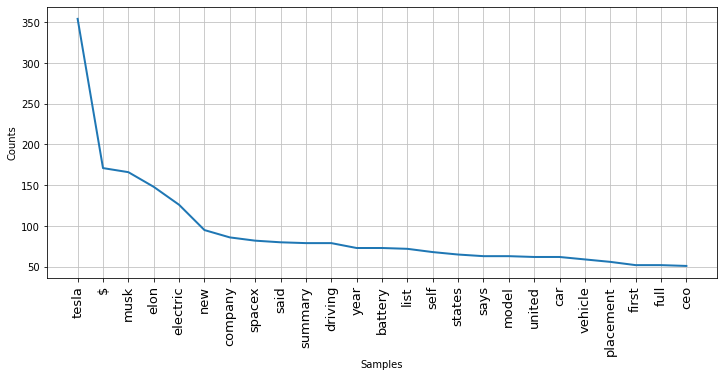

In [16]:
# Plot word frequency distribution
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(word_frequency)
fd.plot(25,cumulative=False)

# Log-log of all words 
word_counts = sorted(Counter(word_frequency).values(), reverse=True)

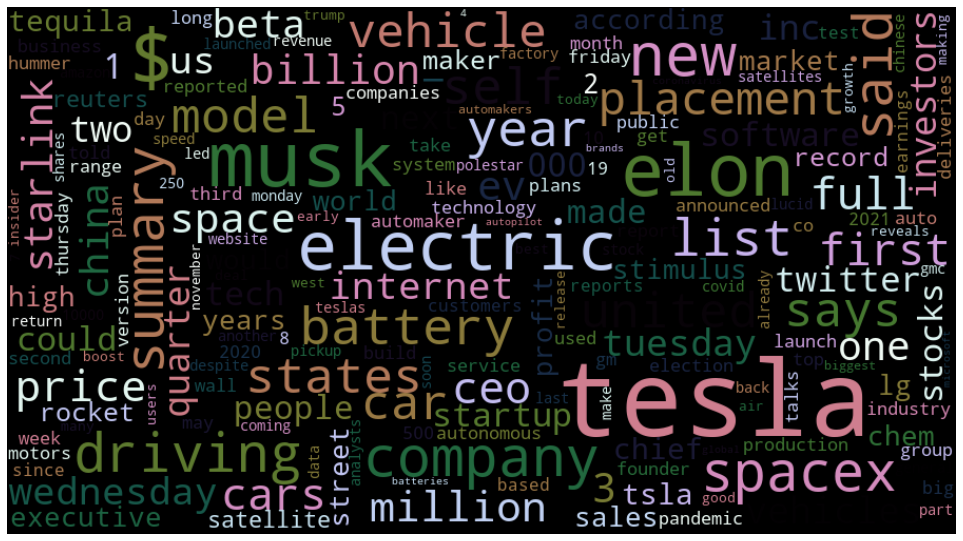

In [17]:
# Generate Word Cloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(word_frequency)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **NLTK Vader Sentiment Lexicon**
Calculate sentiment polarity of sentence

In [18]:
def calculate_sentiment_polarity(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)  

    return sentiment_score["compound"]

In [19]:
# Calculate the sentiment polarity of the news title text
news_stock_label_df["title_sentiment"] = news_stock_label_df.apply(lambda row: calculate_sentiment_polarity(row["title"]), axis = 1)

# Calculate the sentiment polarity of the news description text
news_stock_label_df["description_sentiment"] = news_stock_label_df.apply(lambda row: calculate_sentiment_polarity(row["description"]), axis = 1)

news_stock_label_df

,title,description,timestamp,label,title_sentiment,description_sentiment
0,tesla finally launches two factor authentication,long string delays tesla finally implemented c...,2020-10-07,"[0, 0, 0]",0.0000,0.3400
1,tesla shot producing half million cars 2020 memo,tesla inc tsla chance producing 500000 cars ye...,2020-10-07,"[0, 0, 0]",0.0000,0.2500
2,ex,tesla co founder j b straubel wants build star...,2020-10-07,"[0, 0, 0]",0.0000,0.2023
3,spacex launched enough satellites starlink’s u...,timeline uncertain newly launched satellites m...,2020-10-07,"[0, 0, 0]",0.1280,-0.1531
4,spacex doubled clearing village building rocke...,summary list placementspacex made calls final ...,2020-10-07,"[0, 0, 0]",-0.1280,0.5574
...,...,...,...,...,...,...
472,tesla unveils tesla tequila $ 250 product sold...,tesla inc tsla chief executive officer elon mu...,2020-11-06,"[0, 1, 0]",0.0000,0.5994
473,waiting winner costly investor lessons post el...,investors traditionally shied away uncertainty...,2020-11-06,"[0, 1, 0]",0.5267,0.1586
474,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]",0.0258,0.6808
475,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]",0.0258,0.8074


In [20]:
# Calculate news title and description max length
def get_max_length(row, max_length, text_type):
    max_length[text_type] = str(len(row[text_type].split(" "))) if len(row[text_type].split(" ")) > int(max_length[text_type]) else str(max_length[text_type])
    
    return max_length

In [21]:
# Keep track of the maximum lengths of the news title text and description
max_length = {
    "title": 0,
    "description": 0
}

# Get news title max length
news_stock_label_df.apply(lambda row: get_max_length(row, max_length, "title"), axis = 1)

# Get news description max length
news_stock_label_df.apply(lambda row: get_max_length(row, max_length, "description"), axis = 1)

# Print the max. length of title and description
print("Max length of title:       {}".format(max_length["title"]))
print("Max length of description: {}".format(max_length["description"]))

Max length of title:       27
Max length of description: 39


# **Import BERT Tokenizer & Model**
Load pre-trained BERT transformer & need to tokenize our data in the same way how the transformer was trained

In [22]:
from transformers import BertTokenizer, BertModel

PRE_TRAINED_MODEL_NAME = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# No. of BERT vocab
print("Size of BERT Vocab: {}".format(len(tokenizer.vocab)))

Size of BERT Vocab: 30522


In [23]:
def bert_encoder(row, text_type):
    # Generate the BERT inputs (input_ids, attention_mask, seg_ids) with BERT tokenizer
    # With BERT required special tokens & pad to max length
    encoding = tokenizer.encode_plus(
                  row[text_type],
                  max_length = int(max_length[text_type]),
                  truncation = True,
                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                  return_token_type_ids = False,
                  padding = "max_length",
                  return_attention_mask = True
                ) 
    
    # 1 sentence classification only
    encoding["seg_ids"] = [0] * len(encoding['input_ids'])
    
    return encoding["input_ids"], encoding["attention_mask"], encoding["seg_ids"]
            
# Convert ids back to original tokens
# tokenizer.convert_ids_to_tokens(encoding['input_ids'])

In [24]:
# Get news title BERT input_ids, attention_mask, and seg_ids
news_stock_label_df["title_input_ids"], news_stock_label_df["title_attn_masks"], news_stock_label_df["title_seg_ids"] = zip(*news_stock_label_df.apply(lambda row: bert_encoder(row, "title"), axis = 1))

# Get news description BERT input_ids, attention_mask, and seg_ids
news_stock_label_df["description_input_ids"], news_stock_label_df["description_attn_masks"], news_stock_label_df["description_seg_ids"] = zip(*news_stock_label_df.apply(lambda row: bert_encoder(row, "description"), axis = 1))

news_stock_label_df

,title,description,timestamp,label,title_sentiment,description_sentiment,title_input_ids,title_attn_masks,title_seg_ids,description_input_ids,description_attn_masks,description_seg_ids
0,tesla finally launches two factor authentication,long string delays tesla finally implemented c...,2020-10-07,"[0, 0, 0]",0.0000,0.3400,"(101, 26060, 2633, 18989, 2048, 5387, 27280, 1...","(1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 2146, 5164, 14350, 26060, 2633, 7528, 10...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,tesla shot producing half million cars 2020 memo,tesla inc tsla chance producing 500000 cars ye...,2020-10-07,"[0, 0, 0]",0.0000,0.2500,"(101, 26060, 2915, 5155, 2431, 2454, 3765, 126...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 26060, 4297, 24529, 2721, 3382, 5155, 13...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ex,tesla co founder j b straubel wants build star...,2020-10-07,"[0, 0, 0]",0.0000,0.2023,"(101, 4654, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 26060, 2522, 3910, 1046, 1038, 2358, 252...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,spacex launched enough satellites starlink’s u...,timeline uncertain newly launched satellites m...,2020-10-07,"[0, 0, 0]",0.1280,-0.1531,"(101, 2686, 2595, 3390, 2438, 14549, 2732, 137...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 17060, 9662, 4397, 3390, 14549, 2442, 33...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,spacex doubled clearing village building rocke...,summary list placementspacex made calls final ...,2020-10-07,"[0, 0, 0]",-0.1280,0.5574,"(101, 2686, 2595, 11515, 8430, 2352, 2311, 759...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 12654, 2862, 11073, 23058, 2595, 2081, 4...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
472,tesla unveils tesla tequila $ 250 product sold...,tesla inc tsla chief executive officer elon mu...,2020-11-06,"[0, 1, 0]",0.0000,0.5994,"(101, 26060, 4895, 3726, 12146, 26060, 26791, ...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 26060, 4297, 24529, 2721, 2708, 3237, 29...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
473,waiting winner costly investor lessons post el...,investors traditionally shied away uncertainty...,2020-11-06,"[0, 1, 0]",0.5267,0.1586,"(101, 3403, 3453, 17047, 14316, 8220, 2695, 26...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 9387, 6964, 11895, 2098, 2185, 12503, 84...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
474,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]",0.0258,0.6808,"(101, 11742, 6153, 22752, 15606, 9932, 13275, ...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 15606, 9932, 6153, 11742, 5013, 13058, 2...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
475,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]",0.0258,0.8074,"(101, 11742, 6153, 22752, 15606, 9932, 13275, ...","(1

# **Split data into training and testing sets**

In [25]:
def convert_to_ndarray(data):
    return np.asarray(list(data)).astype("float32")

# Split data into training and testing sets
# Validation data will be created during training
# 90:10 split
news_title_train, news_title_test, y_train, y_test = train_test_split(news_stock_label_df["title"], news_stock_label_df["label"], test_size = 0.1)#, random_state = 2)

# Convert to Numpy Arrays as TF inputs
news_title_train_input_ids, news_title_train_attn_masks, news_title_train_seg_ids = convert_to_ndarray(news_stock_label_df["title_input_ids"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["title_attn_masks"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["title_seg_ids"][news_title_train.index])
news_title_test_input_ids, news_title_test_attn_masks, news_title_test_seg_ids = convert_to_ndarray(news_stock_label_df["title_input_ids"][news_title_test.index]), convert_to_ndarray(news_stock_label_df["title_attn_masks"][news_title_test.index]), convert_to_ndarray(news_stock_label_df["title_seg_ids"][news_title_test.index])

news_description_train_input_ids, news_description_train_attn_masks, news_description_train_seg_ids = convert_to_ndarray(news_stock_label_df["description_input_ids"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["description_attn_masks"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["description_seg_ids"][news_title_train.index])
news_description_test_input_ids, news_description_test_attn_masks, news_description_test_seg_ids = convert_to_ndarray(news_stock_label_df["description_input_ids"][news_title_test.index]), convert_to_ndarray(news_stock_label_df["description_attn_masks"][news_title_test.index]), convert_to_ndarray(news_stock_label_df["description_seg_ids"][news_title_test.index])

news_title_sentiment_train, news_title_sentiment_test = convert_to_ndarray(news_stock_label_df["title_sentiment"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["title_sentiment"][news_title_test.index])
news_description_sentiment_train, news_description_sentiment_test = convert_to_ndarray(news_stock_label_df["description_sentiment"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["description_sentiment"][news_title_test.index])

y_train, y_test = convert_to_ndarray(y_train), convert_to_ndarray(y_test)

In [26]:
# Check the splits length
print("Length of train sets: {}".format(len(y_train)))
print("Length of test  sets: {}".format(len(y_test)))
print("Total length of sets: {}".format(len(news_stock_label_df)))

Length of train sets: 429
Length of test  sets: 48
Total length of sets: 477


# **Fine-tune BERT-MLP (Multi-layer Perceptron) Model with Grid-Search**
A BERT Fine-tuning Approach based on https://arxiv.org/pdf/1810.04805.pdf

In [27]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /var/folders/ns/_kqgbcg519q8s6wms2kght800000gn/T/tfhub_modules to cache modules.


In [28]:
def build_model():
    # Model hyperparameters
    weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
    hidden_dims = 512
    
    # Grid search hyperparameters
    #dropout = 0.1
    #learning_rate = 0.001
    #sentiment = True
    #wider = True
    #deeper = True

    if wider == True:
        hidden_dims *= 2
    
    ###### News Title Model ######
    
    title_inputs = dict(
        input_word_ids = Input(shape=(int(max_length["title"],)), dtype=tf.int32, name="title_input_ids"),
        input_mask = Input(shape=(int(max_length["title"],)), dtype=tf.int32, name="title_attn_masks"),
        input_type_ids = Input(shape=(int(max_length["title"],)), dtype=tf.int32, name="title_seg_ids")
    )

    title_outputs = bert_layer(title_inputs)
    title_BERT_hidden_states = title_outputs["sequence_output"][:, 0, :]
    
    ###### News Description Model ######
    description_inputs = dict(
        input_word_ids = Input(shape=(int(max_length["description"],)), dtype=tf.int32, name="desc_input_ids"),
        input_mask = Input(shape=(int(max_length["description"],)), dtype=tf.int32, name="desc_attn_masks"),
        input_type_ids = Input(shape=(int(max_length["description"],)), dtype=tf.int32, name="desc_seg_ids")
    )
                        
    desc_outputs = bert_layer(description_inputs)
    desc_BERT_hidden_states = desc_outputs["sequence_output"][:, 0, :]
    
    ###### Concatenated Model ######
    if sentiment:
        # With news title & description sentiment
        title_sentiment = Input(shape=(1,), name="title_sentiment")
        description_sentiment = Input(shape=(1,), name="description_sentiment")
        model_concat = concatenate([title_BERT_hidden_states, desc_BERT_hidden_states, title_sentiment, description_sentiment])
    
    else:
        # Without news title & description sentiment
        model_concat = concatenate([title_BERT_hidden_states, desc_BERT_hidden_states])
    
    model_concat = Dense(hidden_dims, kernel_initializer=weights, activation="relu", name="concat_Dense")(model_concat)
    model_concat = Dropout(dropout, name="concat_Dense_dropout")(model_concat)
    
    if deeper == True:
        x = Dense(hidden_dims//2, kernel_initializer=weights, activation="relu", name="concat_Dense_l2")(model_concat)
        x = Dropout(dropout, name="concat_Dense_l2_dropout")(model_concat)

    output = Dense(3,
                   kernel_initializer=weights,
                   activation="softmax",
                   name="output")(model_concat)   
        
    if sentiment:
        # With news title & description sentiment
        model = Model(inputs=[title_inputs["input_word_ids"], title_inputs["input_mask"], title_inputs["input_type_ids"], description_inputs["input_word_ids"], description_inputs["input_mask"], description_inputs["input_type_ids"], title_sentiment, description_sentiment], outputs=[output])
    else:
        # Without news title & description sentiment
        model = Model(inputs=[title_inputs["input_word_ids"], title_inputs["input_mask"], title_inputs["input_type_ids"], description_inputs["input_word_ids"], description_inputs["input_mask"], description_inputs["input_type_ids"]], outputs=[output])
    
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=learning_rate),
                  metrics=["accuracy"])

    return model

In [29]:
# Create save folders if not exist
if not os.path.exists("../data/{}/saved_models".format(ticker)):
    os.makedirs("../data/{}/saved_models".format(ticker))

# Grid Search to tune hyperparameters

# Without or With Sentiment (Title & Description)
for sentiment in [False, True]:
    # Extra deep layers
    for deeper in [True]:
        # Double the hyperparameter values
        for wider in [True]:
            for learning_rate in [0.0001]:
                # Different dropout rates
                for dropout in [0.3]:
                    model = build_model()
                    print("")
                    print("Currently training model with: Sentiment={} Deeper={}, Wider={}, LR={}, Dropout={}".format(sentiment, deeper, wider, learning_rate, dropout))
                    print("")
                    
                    save_best_weights = '../data/{}/saved_models/{}_bert_model_sentiment={}_deeper={}_wider={}_lr={}_dropout={}.h5'.format(ticker, ticker, sentiment, deeper, wider, learning_rate, dropout)

                    # Checkpoint with EarlyStopping and Auto reduce learning rate 
                    callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                                 EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                    if sentiment:
                        x_train = [news_title_train_input_ids, news_title_train_attn_masks, news_title_train_seg_ids, news_description_train_input_ids, news_description_train_attn_masks, news_description_train_seg_ids, news_title_sentiment_train, news_description_sentiment_train]            
                    else:
                        x_train = [news_title_train_input_ids, news_title_train_attn_masks, news_title_train_seg_ids, news_description_train_input_ids, news_description_train_attn_masks, news_description_train_seg_ids]
                    
                    # Train the model
                    history = model.fit(x_train,
                                        y_train,
                                        batch_size = 128,
                                        epochs = 100,
                                        validation_split = 0.15,
                                        verbose = True,
                                        shuffle = True,
                                        callbacks = callbacks)


Currently training model with: Sentiment=False Deeper=True, Wider=True, LR=0.0001, Dropout=0.3

Epoch 1/100
3/3 [==============================] - 51s 17s/step - loss: 2.2806 - accuracy: 0.3462 - val_loss: 1.0865 - val_accuracy: 0.3385
Epoch 2/100
3/3 [==============================] - 48s 16s/step - loss: 1.1461 - accuracy: 0.4286 - val_loss: 1.2448 - val_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 47s 16s/step - loss: 1.3916 - accuracy: 0.4011 - val_loss: 1.6576 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - 50s 17s/step - loss: 1.9505 - accuracy: 0.3626 - val_loss: 1.0851 - val_accuracy: 0.4000
Epoch 5/100
3/3 [==============================] - 50s 17s/step - loss: 1.8344 - accuracy: 0.3929 - val_loss: 1.3460 - val_accuracy: 0.4000
Epoch 6/100
3/3 [==============================] - 52s 17s/step - loss: 1.7359 - accuracy: 0.4011 - val_loss: 0.6345 - val_accuracy: 0.3846
Epoch 7/100
3/3 [==============================] - 49s 16s/step

In [30]:
# NOT RUN DURING ACTIVE TRAINING -- FOR REFERENCE ONLY
# Sample model with default hyperparameters
model = build_model()
print(model.summary())

# Clean-up the model
del model
tf.keras.backend.clear_session()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_attn_masks (InputLayer)   [(None, 27)]         0                                            
__________________________________________________________________________________________________
title_seg_ids (InputLayer)      [(None, 27)]         0                                            
__________________________________________________________________________________________________
title_input_ids (InputLayer)    [(None, 27)]         0                                            
__________________________________________________________________________________________________
desc_attn_masks (InputLayer)    [(None, 39)]         0                                            
_______________________________________________________________________________________

# **Evaluate BERT Model Prediction**

In [31]:
def evaluate(parameters, test_data):
    sentiment, deeper, wider, learning_rate, dropout = parameters
    
    # Rebuild model based on saved weights
    model = build_model()
    model.load_weights('../data/{}/saved_models/{}_bert_model_sentiment={}_deeper={}_wider={}_lr={}_dropout={}.h5'.format(ticker, ticker, sentiment, deeper, wider, learning_rate, dropout))

    predictions = model.predict(test_data, verbose=True)
    
    # Get the true & predicted softmax classes
    y_true = label_binarize(np.argmax(y_test, axis=-1), classes=[0, 1, 2])
    y_pred = label_binarize(np.argmax(predictions, axis=-1), classes=[0, 1, 2])
    
    print()
    # Accuracy: (tp + tn) / (p + n)
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    print(f"Accuracy: {accuracy}")

    # Precision: tp / (tp + fp)
    precision = round(precision_score(y_true, y_pred, average='micro'), 3)
    print(f"Precision: {precision}")

    # Recall: tp / (tp + fn)
    recall = round(recall_score(y_true, y_pred, average='micro'), 3)
    print(f"Recall: {recall}")

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = round(f1_score(y_true, y_pred, average='micro'), 3)
    print(f"F1 score: {f1}")
    
    del model
    tf.keras.backend.clear_session()

In [32]:
# Make predictions with the best model hyperparameters (via Grid Search)
deeper = True
wider = True
dropout = 0.3
learning_rate = 0.0001

# Evaluate (baseline) model without sentiment
sentiment = False
parameters = (sentiment, deeper, wider, learning_rate, dropout)
test_data = [news_title_test_input_ids, news_title_test_attn_masks, news_title_test_seg_ids, news_description_test_input_ids, news_description_test_attn_masks, news_description_test_seg_ids]
                    
print("Baseline BERT Model\n")
evaluate(parameters, test_data)

Baseline BERT Model

2/2 [==============================] - 1s 361ms/step

Accuracy: 0.458
Precision: 0.458
Recall: 0.458
F1 score: 0.458


In [33]:
# Evaluate model with news title & description sentiment polarities
sentiment = True
parameters = (sentiment, deeper, wider, learning_rate, dropout)
test_data = [news_title_test_input_ids, news_title_test_attn_masks, news_title_test_seg_ids, news_description_test_input_ids, news_description_test_attn_masks, news_description_test_seg_ids, news_title_sentiment_test, news_description_sentiment_test] 

print("BERT Model with Sentiment Polarity\n")
evaluate(parameters, test_data)

BERT Model with Sentiment Polarity

2/2 [==============================] - 1s 381ms/step

Accuracy: 0.458
Precision: 0.458
Recall: 0.458
F1 score: 0.458


# **Prediction with own data**

In [34]:
own_news_data = {
    "title": ["Joe Biden has won the presidency"],
    "description": ["The outcome of the 2020 election could have far reaching implications for the economy. \
                     The Street expects the economy to recover under a Democratic sweep."]
}

df = pd.DataFrame(own_news_data)

In [35]:
# Clean the news title & description text
df["title"] = df.apply(lambda row: clean_text(row["title"]), axis=1)
df["description"] = df.apply(lambda row: clean_text(row["description"]), axis = 1)

# Calculate the sentiment polarity of the news title & description text
df["title_sentiment"] = df.apply(lambda row: calculate_sentiment_polarity(row["title"]), axis=1)
df["description_sentiment"] = df.apply(lambda row: calculate_sentiment_polarity(row["description"]), axis=1)

# Get news title BERT input_ids, attention_mask, and seg_ids
df["title_input_ids"], df["title_attn_masks"], df["title_seg_ids"] = zip(*df.apply(lambda row: bert_encoder(row, "title"), axis = 1))

# Get news description BERT input_ids, attention_mask, and seg_ids
df["description_input_ids"], df["description_attn_masks"], df["description_seg_ids"] = zip(*df.apply(lambda row: bert_encoder(row, "description"), axis = 1))

df

,title,description,title_sentiment,description_sentiment,title_input_ids,title_attn_masks,title_seg_ids,description_input_ids,description_attn_masks,description_seg_ids
0,joe biden presidency,outcome 2020 election could far reaching impli...,0.0,0.2023,"(101, 3533, 7226, 2368, 8798, 102, 0, 0, 0, 0,...","(1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(101, 9560, 12609, 2602, 2071, 2521, 4285, 134...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [36]:
class_dict = {
    0: "stay",
    1: "up",
    2: "down"
}

# Rebuild model based on saved weights
sentiment = True
deeper = True
wider = True
dropout = 0.3
learning_rate = 0.0001

model = build_model()
model.load_weights('../data/{}/saved_models/{}_bert_model_sentiment={}_deeper={}_wider={}_lr={}_dropout={}.h5'.format(ticker, ticker, sentiment, deeper, wider, learning_rate, dropout))

# Prepare prediction data & perform prediction
predict_data = [convert_to_ndarray(df["title_input_ids"]), convert_to_ndarray(df["title_attn_masks"]), convert_to_ndarray(df["title_seg_ids"]), convert_to_ndarray(df["description_input_ids"]), convert_to_ndarray(df["description_attn_masks"]), convert_to_ndarray(df["description_seg_ids"]), convert_to_ndarray(df["title_sentiment"]), convert_to_ndarray(df["description_sentiment"])]
prediction = np.argmax(model.predict(predict_data, verbose=True), axis=-1)

print()
print(f"Predicted {ticker} stock trend: {class_dict[prediction[0]]}")
print()

1/1 [==============================] - 0s 802us/step

Predicted TSLA stock trend: up



# **End of Notebook**